# 非线性激活函数量化——查表法

In [26]:
import matplotlib.pyplot as plt
import time
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [27]:
# 量化比特数
bit_nums = 8
# lut表大小
lut_size = 256

q_min = 0
q_max = 2 ** bit_nums - 1

in_scale = (127+128) / (2 ** bit_nums - 1)
in_zp = np.clip(np.round(q_max - 127 / in_scale), q_min, q_max)
out_scale = 1 / (2 ** bit_nums - 1)
out_zp = np.clip(np.round(q_max - 1 / out_scale), q_min, q_max)

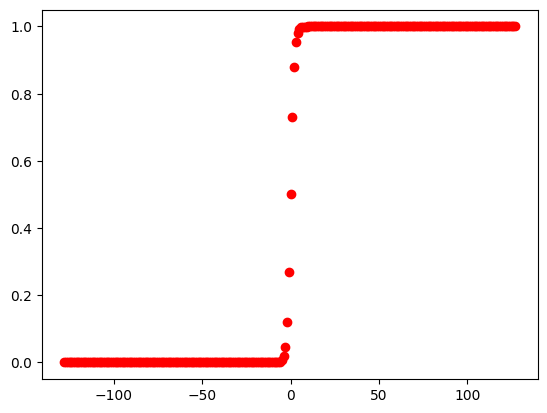

In [28]:
# 生成 lut 表的采样点
q_x = np.round(np.linspace(0, 2 ** bit_nums - 1, lut_size))
# 反量化到 [-10, 10]
x = (q_x - in_zp) * in_scale
# 计算 sigmoid 函数的值
y = sigmoid(x)
# 函数值量化到 [0, 255]
q_y = np.clip(np.round(y / out_scale) + out_zp, q_min, q_max)
plt.plot(x, y, 'ro')

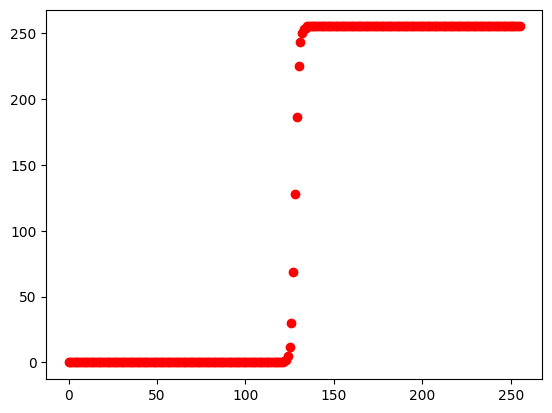

In [29]:
plt.plot(q_x, q_y, 'ro')

## 推理阶段

In [30]:
x=2
q_x1=np.round(x/in_scale)+in_zp
y=np.interp(q_x1, q_x, q_y)
print(y)
y=(y-out_zp)*out_scale
print(y)

225.0
0.8823529411764706


In [31]:
print(sigmoid(2))

0.8807970779778823


## 非线性函数电路

In [32]:
from concrete import fhe
table = fhe.LookupTable(q_y.astype(np.int32))

@fhe.compiler({"q_x": "encrypted"})
def q_sigmoid(q_x):
    return table[q_x]

inputset = range(0,256)
circuit = q_sigmoid.compile(inputset)

print(circuit)

%0 = q_x                                             # EncryptedScalar<uint8>        ∈ [0, 255]
%1 = tlu(%0, table=[  0   0   ... 5 255 255])        # EncryptedScalar<uint8>        ∈ [0, 255]
return %1


In [34]:
x=12
q_x1=np.round(x/in_scale)+in_zp
print(q_x1)
y=np.interp(q_x1, q_x, q_y)
print(y)
y=(y-out_zp)*out_scale
print(y)

140.0
255.0
1.0


In [35]:
#生成密钥时间
start=time.time()
circuit.keygen()
end=time.time()
print("keygen_time:",end-start)

keygen_time: 115.37499594688416


In [47]:
#加密时间
x=12
q_x1=(np.round(x/in_scale)+in_zp).astype(np.int32)
print(q_x1)
start=time.time()
enc_q_x1=circuit.encrypt(q_x1)
end=time.time()
print("encrypt_time:",end-start)

140
encrypt_time: 0.0009417533874511719


In [48]:
#运行时间
start=time.time()
enc_q_x1=circuit.run(enc_q_x1)
end=time.time()
print("run_time:",end-start)

run_time: 1.1920018196105957


In [49]:
# 解密时间
start=time.time()
q_result=circuit.decrypt(enc_q_x1)
end=time.time()
print("decrypt_time:",end-start)
print("q_result:",q_result)
print("result:",(q_result-out_zp)*out_scale)
print("sigmoid_result:",sigmoid(x))

decrypt_time: 0.0001697540283203125
q_result: 255
result: 1.0
sigmoid_result: 0.9999938558253978


In [50]:
print(q_x)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [51]:
print(q_y)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   2.   5.  12.
  30.  69. 128. 186. 225. 243. 250. 253. 254. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 

## 测试非线性函数的运行时间

### 量化比特数为8

In [52]:
# 量化比特数
bit_nums = 8
# lut表大小
lut_size = 2**bit_nums

q_min = 0
q_max = 2 ** bit_nums - 1
r_max=2**(bit_nums-1)-1
r_min=-2**(bit_nums-1)

in_scale = (r_max-r_min) / (2 ** bit_nums - 1)
in_zp = np.clip(np.round(q_max - r_max / in_scale), q_min, q_max)
out_scale = 1 / (2 ** bit_nums - 1)
out_zp = np.clip(np.round(q_max - 1 / out_scale), q_min, q_max)

# 生成 lut 表的采样点
q_x = np.round(np.linspace(0, 2 ** bit_nums - 1, lut_size))
# 反量化到 [-128, 127]
x = (q_x - in_zp) * in_scale
# 计算 sigmoid 函数的值
y = sigmoid(x)
# 函数值量化到 [0, 255]
q_y = np.clip(np.round(y / out_scale) + out_zp, q_min, q_max)

table_8 = fhe.LookupTable(q_y.astype(np.int32))
def q_sigmoid(n_bits: int, inputs:np.ndarray):

    @fhe.compiler({"q_x": "encrypted"})
    def q_sigmoid(q_x):
        return table_8[q_x]

    inputset = [np.random.randint(0, 2 ** n_bits - 1, size=inputs.shape)
              for i in range(10000)]
    circuit = q_sigmoid.compile(inputset)

    return circuit

In [53]:
inputs=np.array([2]).astype(np.float32)
circuit=q_sigmoid(8,inputs)

In [54]:
#生成密钥时间
start=time.time()
circuit.keygen()
end=time.time()
print("keygen_time:",end-start)

keygen_time: 123.89326024055481


In [62]:
x1=np.array([12])
q_x1=(np.round(x1/in_scale)+in_zp).astype(np.int32)
print(q_x1)
#加密时间
start=time.time()
enc_q_x1=circuit.encrypt(q_x1)
end=time.time()
print("encrypt_time:",end-start)

[140]
encrypt_time: 0.0010941028594970703


In [63]:
#运行时间
start=time.time()
enc_q_x1=circuit.run(enc_q_x1)
end=time.time()
print("run_time:",end-start)

run_time: 1.2688989639282227


In [65]:
# 解密时间
start=time.time()
q_result=circuit.decrypt(enc_q_x1)
end=time.time()
print("decrypt_time:",end-start)
print("q_result:",q_result)
print("result:",(q_result-out_zp)*out_scale)
print("sigmoid_result:",sigmoid(x1))

decrypt_time: 0.0001690387725830078
q_result: [255]
result: [1.]
sigmoid_result: [0.99999386]


### 量化比特数为4

In [66]:
# 量化比特数
bit_nums = 4
# lut表大小
lut_size = 2**bit_nums

q_min = 0
q_max = 2 ** bit_nums - 1
r_max=2**(bit_nums-1)-1
r_min=-2**(bit_nums-1)

in_scale = (r_max-r_min) / (2 ** bit_nums - 1)
in_zp = np.clip(np.round(q_max - r_max / in_scale), q_min, q_max)
out_scale = 1 / (2 ** bit_nums - 1)
out_zp = np.clip(np.round(q_max - 1 / out_scale), q_min, q_max)

# 生成 lut 表的采样点
q_x = np.round(np.linspace(0, 2 ** bit_nums - 1, lut_size))
# 反量化到 [-128, 127]
x = (q_x - in_zp) * in_scale
# 计算 sigmoid 函数的值
y = sigmoid(x)
# 函数值量化到 [0, 255]
q_y = np.clip(np.round(y / out_scale) + out_zp, q_min, q_max)

table_4 = fhe.LookupTable(q_y.astype(np.int32))
def q_sigmoid(n_bits: int, inputs:np.ndarray):

    @fhe.compiler({"q_x": "encrypted"})
    def q_sigmoid(q_x):
        return table_4[q_x]

    inputset = [np.random.randint(0, 2 ** n_bits - 1, size=inputs.shape)
              for i in range(10000)]
    circuit = q_sigmoid.compile(inputset)

    return circuit

In [72]:
inputs=np.array([2]).astype(np.float32)
circuit=q_sigmoid(4,inputs)

In [73]:
#生成密钥时间
start=time.time()
circuit.keygen()
end=time.time()
print("keygen_time:",end-start)

keygen_time: 1.565321445465088


In [77]:
x1=np.array([2])
q_x1=(np.round(x1/in_scale)+in_zp).astype(np.int32)
print(q_x1)
#加密时间
start=time.time()
enc_q_x1=circuit.encrypt(q_x1)
end=time.time()
print("encrypt_time:",end-start)

[10]
encrypt_time: 0.0005156993865966797


In [78]:
#运行时间
start = time.time()
enc_q_x1 = circuit.run(enc_q_x1)
end = time.time()
print("run_time:", end - start)

run_time: 0.1835041046142578


In [80]:
# 解密时间
start=time.time()
q_result=circuit.decrypt(enc_q_x1)
end=time.time()
print("decrypt_time:",end-start)
print("q_result:",q_result)
print("result:",(q_result-out_zp)*out_scale)
print("sigmoid_result:",sigmoid(2))

decrypt_time: 0.00016617774963378906
q_result: [13]
result: [0.86666667]
sigmoid_result: 0.8807970779778823


## PTQSigmoid

In [81]:
import time

import torch
import torch.nn as nn
from concrete.ml.torch.compile import compile_torch_model


class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(x)
        return x


input = torch.randn(10, 1)
model = net()


def testSigmoidPTQ(n_bits):
    # 模型编译时间
    start_time = time.time()
    quantized_module = compile_torch_model(
        model,  # our model
        input,  # a representative input-set to be used for both quantization and compilation
        n_bits=n_bits,
    )
    end_time = time.time()
    print("编译时间", end_time - start_time)
    print("量化位数：", n_bits, "最大量化位数", quantized_module.fhe_circuit.graph.maximum_integer_bit_width())

    return quantized_module



In [82]:
quantized_module=testSigmoidPTQ(8)

编译时间 0.23333096504211426
量化位数： 8 最大量化位数 8


In [84]:
x_test = torch.randn(1, 1).numpy()
# 推理时间
start_time = time.time()
y_pred = quantized_module.forward(x_test, fhe="execute")
end_time = time.time()
print("推理时间", end_time - start_time)
print("输入值：", x_test, "输出值:", y_pred)
print("*" * 50)
#推理时间 11.45483922958374
# 输入值： [[1.4710562]] 输出值: [[0.71551525]]

推理时间 1.6794917583465576
输入值： [[-1.1643094]] 输出值: [[0.23658166]]
**************************************************


In [85]:
quantized_module=testSigmoidPTQ(4)

编译时间 0.10292196273803711
量化位数： 4 最大量化位数 5


In [87]:
x_test = torch.randn(1, 1).numpy()
# 推理时间
start_time = time.time()
y_pred = quantized_module.forward(x_test, fhe="execute")
end_time = time.time()
print("推理时间", end_time - start_time)
print("输入值：", x_test, "输出值:", y_pred)
print("*" * 50)
# 推理时间 6.931081771850586
# 输入值： [[-2.08333]] 输出值: [[0.22150446]]
# **************************************************

推理时间 0.1715831756591797
输入值： [[-1.3038222]] 输出值: [[0.22150446]]
**************************************************


In [88]:
quantized_module=testSigmoidPTQ(2)

编译时间 0.08968544006347656
量化位数： 2 最大量化位数 5


In [90]:
x_test = torch.randn(1, 1).numpy()
# 推理时间
start_time = time.time()
y_pred = quantized_module.forward(x_test, fhe="execute")
end_time = time.time()
print("推理时间", end_time - start_time)
print("输入值：", x_test, "输出值:", y_pred)
print("*" * 50)
# 推理时间 6.468837022781372
# 输入值： [[0.6526345]] 输出值: [[0.64869164]]
# **************************************************

推理时间 0.16655898094177246
输入值： [[-0.4201897]] 输出值: [[0.39554368]]
**************************************************


In [91]:
quantized_module=testSigmoidPTQ(16)

编译时间 25.62351155281067
量化位数： 16 最大量化位数 16


In [93]:
x_test = torch.randn(1, 1).numpy()
# 推理时间
start_time = time.time()
y_pred = quantized_module.forward(x_test, fhe="execute")
end_time = time.time()
print("推理时间", end_time - start_time)
print("输入值：", x_test, "输出值:", y_pred)
print("*" * 50)
# 推理时间 17.66500973701477
# 输入值： [[1.2665664]] 输出值: [[0.71598675]]
# **************************************************


推理时间 3.400249719619751
输入值： [[-1.6689055]] 输出值: [[0.22551259]]
**************************************************
